# Variational autoencoder - CelebA

In [1]:
%pip install -r ../requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import (
    display_img,
    display_grid,
    display_random
)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

sys.path.insert(0, '..')
from dataset import VAEDataset
from models import (
    Encoder,
    Decoder,
    VanillaVAE
)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cuda


# 0. Parameters

In [5]:
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
NUM_FEATURES = 128
Z_DIM = 512
EPOCHS = 10
LR = 1e-4
KL_WEIGHT = 1e-4
LOAD_MODEL = True

# 1. Prepare the data

In [6]:
data_path = '../celeba/'

data = VAEDataset(data_path=data_path,
                  batch_size=BATCH_SIZE,
                  num_workers=16,
                  pin_memory=True)
data.setup()

# 2. Build VAE

In [7]:
encoder = Encoder(in_channels=3,
                  z_dim=512)
decoder = Decoder(z_dim=512)
vanilla_vae = VanillaVAE(lr=LR,
                         beta=KL_WEIGHT,
                         encoder=encoder,
                         decoder=decoder)

# 3. Train VAE

In [8]:
if LOAD_MODEL:
    vae = VanillaVAE.load_from_checkpoint("../checkpoints/vanilla_vae_30_epochs.ckpt",
                                          lr=1e-4,
                                          beta=1e-4,
                                          encoder=Encoder(in_channels=3, z_dim=512),
                                          decoder=Decoder(z_dim=512))
else:
    """
    It's been noticed that progress bar in bugges in Jupyter Notebook.
    You can try training the model with train.py
    """
    tb_logger = TensorBoardLogger(save_dir='logs/', name='Vanilla VAE')
    trainer = Trainer(logger=tb_logger,
                      accelerator='auto',
                      devices=1,
                      max_epochs=EPOCHS)
    trainer.fit(model=vanilla_vae, datamodule=data)

# 4. Experiments

## 4.1 Reconstructions

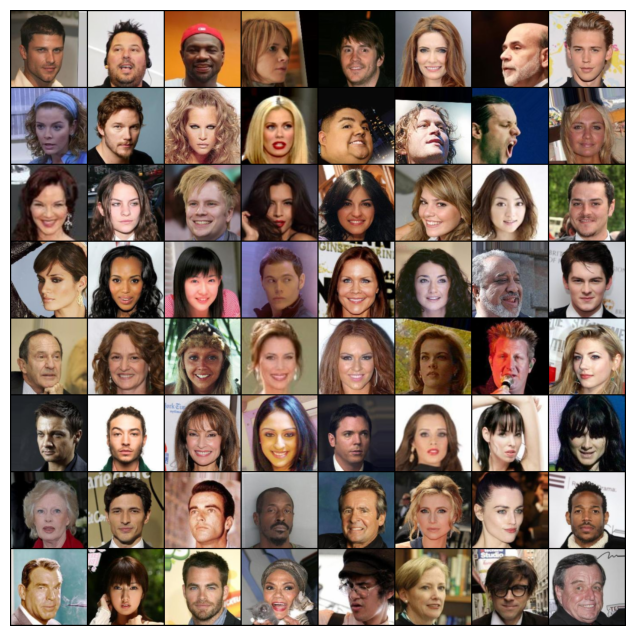

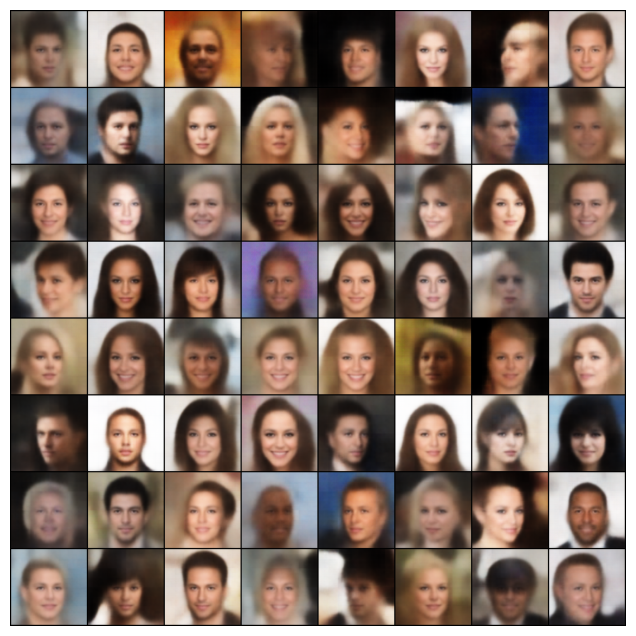

In [9]:
NUM_SAMPLES = 64

indices = torch.randperm(len(data.celeba_train))[:NUM_SAMPLES]

images = torch.stack([data.celeba_train[idx.item()][0] for idx in indices]).to(device)
reconstructions = vae.predict_step(images).to('cpu')
display_grid(images, figsize=(8,8))
plt.savefig('vae_training_data.png', bbox_inches='tight', pad_inches=0, dpi=156)
plt.show()
display_grid(reconstructions, figsize=(8,8))
plt.savefig('vae_reconstruction.png', bbox_inches='tight', pad_inches=0, dpi=156)
plt.show()

## 4.2 Generated celebrities

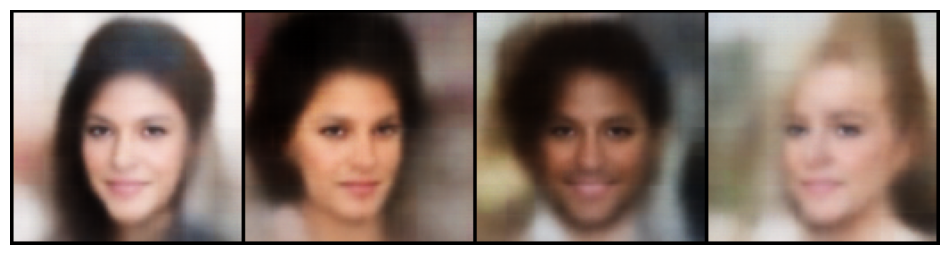

In [10]:
NUM_SAMPLES = 4

samples = torch.randn(NUM_SAMPLES, Z_DIM).to(device)
imgs = vae.decode(samples).to(device)
display_grid(imgs, 4)

### Split dataset into female and male samples. Sum up vectors of the same classes.

In [12]:
male_sum = None
num_male = 0
female_sum = None
num_female = 0

loader = data.train_dataloader()

for i, batch in enumerate(loader):
    with torch.no_grad():
        if i > 2000:
            break
        print(f'Batch {i}/2000')
        x, labels = batch
        x = x.to(device)
        z_mean, z_log_var = vae.encode(x)
        encodings = vae.sample_z(z_mean, z_log_var)
        
        males_vectors = encodings[(labels == 1).nonzero(as_tuple=True)]
        females_vectors = encodings[(labels == -1).nonzero(as_tuple=True)]

        if male_sum is None and males_vectors.size(0) > 0:
            male_sum = torch.zeros_like(males_vectors[0], device=device)
        if female_sum is None and females_vectors.size(0) > 0:
            female_sum = torch.zeros_like(females_vectors[0], device=device)
        
        if males_vectors.size(0) > 0:
            male_sum += torch.sum(males_vectors, dim=0)
            num_male += males_vectors.size(0)
        
        if females_vectors.size(0) > 0:
            female_sum += torch.sum(females_vectors, dim=0)
            num_female += females_vectors.size(0)

male_mean = male_sum / num_male if num_male > 0 else None
female_mean = female_sum / num_female if num_female > 0 else None

assert male_mean is not None
assert female_mean is not None

/home/mrbekson119/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch 0/2000
Batch 1/2000
Batch 2/2000
Batch 3/2000
Batch 4/2000
Batch 5/2000
Batch 6/2000
Batch 7/2000
Batch 8/2000
Batch 9/2000
Batch 10/2000
Batch 11/2000
Batch 12/2000
Batch 13/2000
Batch 14/2000
Batch 15/2000
Batch 16/2000
Batch 17/2000
Batch 18/2000
Batch 19/2000
Batch 20/2000
Batch 21/2000
Batch 22/2000
Batch 23/2000
Batch 24/2000
Batch 25/2000
Batch 26/2000
Batch 27/2000
Batch 28/2000
Batch 29/2000
Batch 30/2000
Batch 31/2000
Batch 32/2000
Batch 33/2000
Batch 34/2000
Batch 35/2000
Batch 36/2000
Batch 37/2000
Batch 38/2000
Batch 39/2000
Batch 40/2000
Batch 41/2000
Batch 42/2000
Batch 43/2000
Batch 44/2000
Batch 45/2000
Batch 46/2000
Batch 47/2000
Batch 48/2000
Batch 49/2000
Batch 50/2000
Batch 51/2000
Batch 52/2000
Batch 53/2000
Batch 54/2000
Batch 55/2000
Batch 56/2000
Batch 57/2000
Batch 58/2000
Batch 59/2000
Batch 60/2000
Batch 61/2000
Batch 62/2000
Batch 63/2000
Batch 64/2000
Batch 65/2000
Batch 66/2000
Batch 67/2000
Batch 68/2000
Batch 69/2000
Batch 70/2000
Batch 71/2000
Ba

### Calculate the difference between male and female vector means.

In [13]:
male_to_female = female_mean - male_mean

### Pick some image.

In [14]:
MALE_IDX = 310

interpolation_sample = data.celeba_train[MALE_IDX][0].view(1, 3, 128, 128)

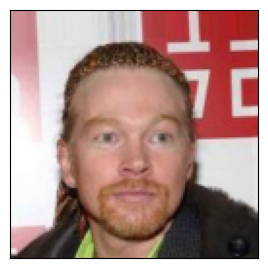

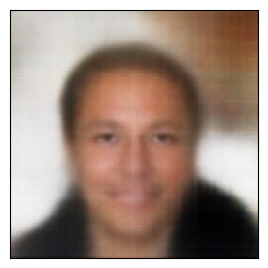

In [15]:
display_img(interpolation_sample)

z_mean, z_log_var = vae.encoder(interpolation_sample.to(device))
interpolation_sample_z = vae.sample_z(z_mean, z_log_var)
display_img(vae.decoder(interpolation_sample_z))

### Transform male into female by moving encoded vector in female vector direction.

In [19]:
results = []
for i in range(-4, 5):
    image = interpolation_sample_z + i * male_to_female
    decoded_image = vae.decoder(image.unsqueeze(0))
    results.append(decoded_image)
results = torch.cat(results, dim=0)

### Display results. Middle image is the original one.

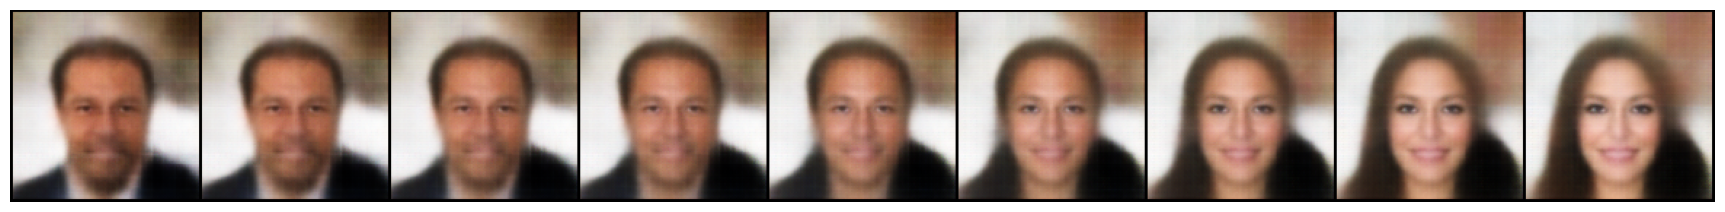

In [20]:
display_grid(results, nrow=9, figsize=(22, 22))
plt.savefig('vae_interpolation.png', bbox_inches='tight', pad_inches=0, dpi=64)
plt.show()